## Setup environment

In [0]:
# !pip install keras==2.2.5

In [0]:
# select Tensorflow 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import sys

print(sys.version_info.major)
# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

3


In [0]:
# load TensorFlow 2 and keras

print('Installing TensorFlow')
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing TensorFlow
TensorFlow version: 2.2.0-rc2


In [0]:
print(keras.__version__)

2.3.0-tf


## Sign language training-letter level

In [0]:
# load keras 
import os, cv2, skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Add, AveragePooling2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import MaxPooling2D, Activation, concatenate
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# ensure consistency across runs
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Imports to view data
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
#os.path.exists('/content/drive/My Drive/W251_final_project/Project - Autobots/Data/asl-alphabet/asl_alphabet_train')
!unzip '/content/drive/My Drive/Colab Notebooks/asl-alphabet.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

In [0]:
# helper function for display the represent images
def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = '/content/asl_alphabet_train/asl_alphabet_train/' + letter
    # img_path = base_path + letter #+ '/**'
    # path_contents = os.glob(img_path)
    imgs = np.random.choice(os.listdir(base_path), size = 3)
    
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(base_path + "/" +imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(base_path + "/" +imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(base_path + "/" +imgs[2]))
    return

Samples images for letter A


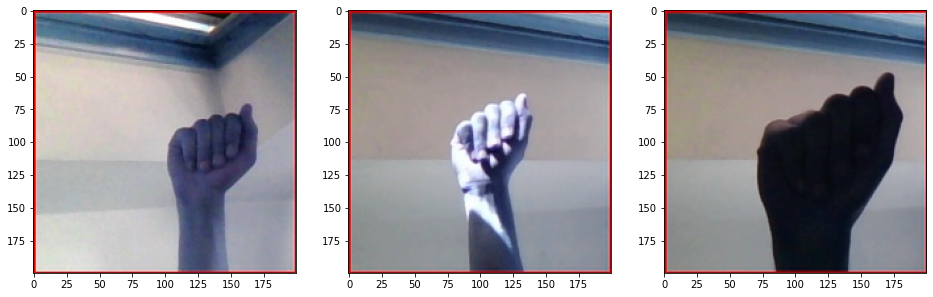

In [0]:
plot_three_samples('A')

### Data Processing Set-Up

In [0]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Using TensorFlow backend.


In [0]:
data_dir = "/content/asl_alphabet_train/asl_alphabet_train/"
target_size = (224, 224)
target_dims = (224, 224, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 32

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [0]:
number_of_steps = int(train_generator.samples / batch_size)
validation_steps = int(val_generator.samples / batch_size)

print('number_of_steps:', number_of_steps)
print('number_of_validation_steps:', validation_steps)


number_of_steps: 2446
number_of_validation_steps: 271


In [0]:
print(train_generator)

### Model Specification

In [0]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=target_dims)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9, decay=0.01)
model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


94773248/94765736 [==============================] - 2s 0us/step


In [0]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
filepath = 'outputs/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath)

trained_model_1 = model.fit(train_generator, steps_per_epoch=number_of_steps, epochs=10, validation_data=val_generator, validation_steps = validation_steps, callbacks = model_checkpoint, use_multiprocessing=False, workers=1)

Epoch 1/10
2446/2446 [==============================] - 212s 86ms/step - loss: 0.5711 - accuracy: 0.8341 - val_loss: 1.3829 - val_accuracy: 0.6509
Epoch 2/10
2446/2446 [==============================] - 217s 89ms/step - loss: 0.5469 - accuracy: 0.8392 - val_loss: 1.3157 - val_accuracy: 0.6686
Epoch 3/10
2446/2446 [==============================] - 214s 88ms/step - loss: 0.5265 - accuracy: 0.8451 - val_loss: 1.3326 - val_accuracy: 0.6665
Epoch 4/10
2446/2446 [==============================] - 208s 85ms/step - loss: 0.5104 - accuracy: 0.8479 - val_loss: 1.2998 - val_accuracy: 0.6614
Epoch 5/10
2446/2446 [==============================] - 208s 85ms/step - loss: 0.5013 - accuracy: 0.8511 - val_loss: 1.2994 - val_accuracy: 0.6680
Epoch 6/10
2446/2446 [==============================] - 212s 87ms/step - loss: 0.4890 - accuracy: 0.8540 - val_loss: 1.2471 - val_accuracy: 0.6750
Epoch 7/10
2446/2446 [==============================] - 212s 87ms/step - loss: 0.4854 - accuracy: 0.8548 - val_loss: 1

In [0]:
# score = model.evaluate(val_generator, verbose=0)
# print('\nKeras CNN - accuracy:', score[1], '\n')

In [0]:
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(lr = 0.01, momentum=0.9, decay=0.001)
model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])  

In [0]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
filepath_final = 'outputs/train_final/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_final = keras.callbacks.ModelCheckpoint(filepath_final, monitor='lo')

trained_model_final = model.fit(train_generator, steps_per_epoch=number_of_steps, epochs=10, validation_data=val_generator, validation_steps = validation_steps, callbacks = model_checkpoint, use_multiprocessing=False, workers=1)

Epoch 1/10
2446/2446 [==============================] - 458s 187ms/step - loss: 0.2329 - accuracy: 0.9489 - val_loss: 0.0624 - val_accuracy: 0.9778
Epoch 2/10
2446/2446 [==============================] - 455s 186ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.0535 - val_accuracy: 0.9837
Epoch 3/10
2446/2446 [==============================] - 455s 186ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0586 - val_accuracy: 0.9823
Epoch 4/10
2446/2446 [==============================] - 455s 186ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0518 - val_accuracy: 0.9844
Epoch 5/10
2446/2446 [==============================] - 455s 186ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0571 - val_accuracy: 0.9828
Epoch 6/10
2446/2446 [==============================] - 455s 186ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0548 - val_accuracy: 0.9832
Epoch 7/10
2446/2446 [==============================] - 454s 186ms/step - loss: 9.1674e-04 - accuracy: 0.9999 - 

In [0]:
history = trained_model_final
history.history

{'accuracy': [0.9488552212715149,
  0.9996678233146667,
  0.9998722076416016,
  0.9998722076416016,
  0.9999616742134094,
  0.9999361038208008,
  0.9999489188194275,
  0.9999489188194275,
  0.9999872446060181,
  0.9999489188194275],
 'loss': [0.23287923634052277,
  0.003260083729401231,
  0.001809311448596418,
  0.0014827826526015997,
  0.001093891798518598,
  0.0011111031053587794,
  0.0009167446987703443,
  0.0008708459790796041,
  0.0008570513455197215,
  0.0007615222712047398],
 'val_accuracy': [0.977849543094635,
  0.9837332963943481,
  0.9823488593101501,
  0.9844254851341248,
  0.9828103184700012,
  0.9831564426422119,
  0.9805030226707458,
  0.9851176738739014,
  0.9829257130622864,
  0.9838486313819885],
 'val_loss': [0.06238524988293648,
  0.053532715886831284,
  0.05856124311685562,
  0.051758773624897,
  0.057100482285022736,
  0.05477507412433624,
  0.06599202007055283,
  0.0522136464715004,
  0.05534924939274788,
  0.053414925932884216]}

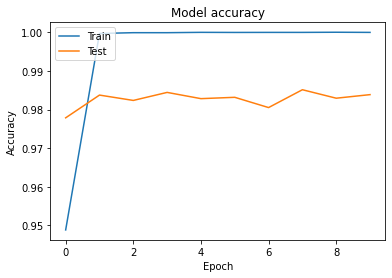

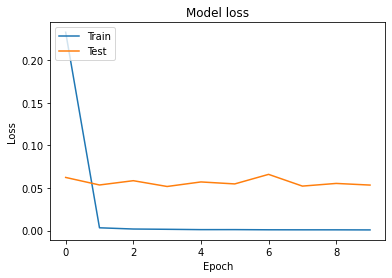

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
yhat_classes = model.predict(val_generator, batch_size=32, steps=271)
yhat_classes

array([[6.7974902e-15, 1.0188591e-13, 2.5600927e-13, ..., 8.8866653e-10,
        3.6703726e-37, 4.9523588e-17],
       [4.3111277e-17, 8.3259765e-16, 4.7761098e-20, ..., 2.1941085e-19,
        3.9930848e-21, 3.4657479e-13],
       [2.0670338e-18, 5.7401640e-19, 3.6062854e-08, ..., 5.0836457e-10,
        6.0077274e-27, 6.8260929e-17],
       ...,
       [6.8152840e-12, 1.2558220e-06, 2.6702124e-12, ..., 1.0327867e-11,
        7.9033277e-25, 2.2206867e-12],
       [1.4540965e-17, 2.3538459e-11, 5.7125845e-12, ..., 6.5892519e-17,
        1.1239346e-32, 3.6087517e-14],
       [3.5426916e-13, 1.8500972e-07, 1.3320609e-14, ..., 9.6069278e-11,
        3.0525418e-16, 8.6051133e-10]], dtype=float32)

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(len(val_generator.classes))
print(val_generator.class_indices)
print(yhat_classes)

accuracy = accuracy_score(val_generator.class_indices, yhat_classes)
print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(val_generator.class_indices, yhat_classes)
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(val_generator.class_indices, yhat_classes)
# print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(val_generator.class_indices, yhat_classes)
# print('F1 score: %f' % f1)

8700
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
[[6.7974902e-15 1.0188591e-13 2.5600927e-13 ... 8.8866653e-10
  3.6703726e-37 4.9523588e-17]
 [4.3111277e-17 8.3259765e-16 4.7761098e-20 ... 2.1941085e-19
  3.9930848e-21 3.4657479e-13]
 [2.0670338e-18 5.7401640e-19 3.6062854e-08 ... 5.0836457e-10
  6.0077274e-27 6.8260929e-17]
 ...
 [6.8152840e-12 1.2558220e-06 2.6702124e-12 ... 1.0327867e-11
  7.9033277e-25 2.2206867e-12]
 [1.4540965e-17 2.3538459e-11 5.7125845e-12 ... 6.5892519e-17
  1.1239346e-32 3.6087517e-14]
 [3.5426916e-13 1.8500972e-07 1.3320609e-14 ... 9.6069278e-11
  3.0525418e-16 8.6051133e-10]]


ValueError: ignored

In [0]:
data_dir = '/content/drive/My Drive/w251_final_project/'
# serialize model to JSON
model_json = model.to_json()
with open(data_dir + "resnet_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(data_dir + "resnet_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
model.save(data_dir + "resnet_model.h5")

In [0]:
import tensorflow as tf

pre_model = tf.keras.models.load_model(data_dir + "resnet_model.h5")
pre_model.save(data_dir + "saved_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/w251_final_project/saved_model/assets
